In [1]:
### Imports for the Notebook

import numpy as np
import pandas as pd

import sys
import pickle

from fastai.vision.all import *
#from torchvision.prototype.models import resnet50
from utils import *
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
path_wiki = 'data/watches/ds1_kaggle/cleandata.csv'
path_imdb = 'data/watches/ds1_kaggle/images/'
img_size = 255

In [3]:
df = pd.read_csv(path_wiki, index_col=0)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=12)

In [4]:
data_imdb = ImageDataLoaders.from_df(df_train, path_imdb, cols=['Code'], folder ='.',item_tfms=Resize(img_size), y_block=RegressionBlock())

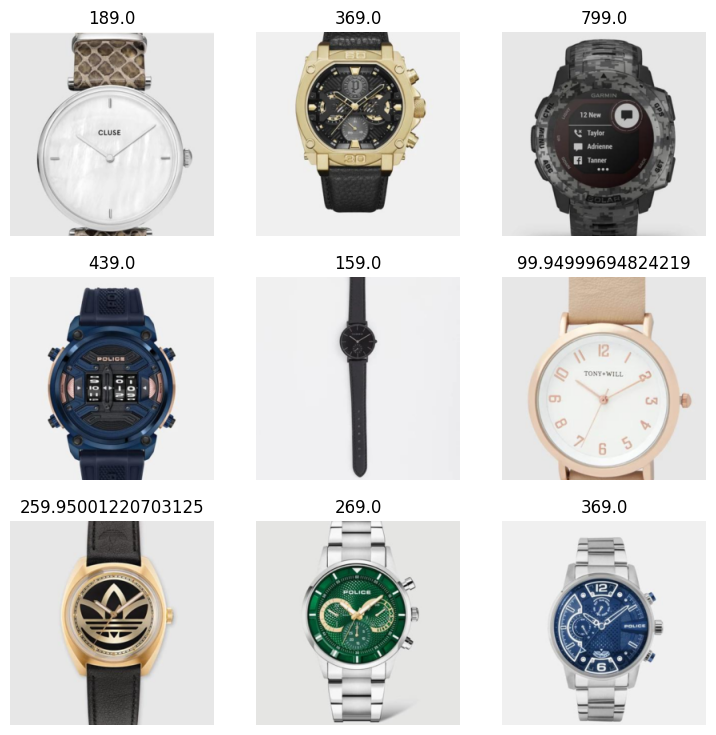

In [5]:
#this function is not necessary and unfortunately sometimes has a bug.
#But when it works, it shows relatively well the loaded data.
#it generates a picture as you can see it in the readme with some picture examples
#but also with a too smwall dataset size it doesn't work
data_imdb.show_batch()

In [6]:
tst = AvgMetric(lambda x,y: (x-y).abs().mean())

In [7]:
%%capture
learn = vision_learner(data_imdb, resnet34, metrics=tst)
learn.loss = MSELossFlat

## Find the right Learningrate

The goal in the next step ist that we find the best learningrate. 
We don't want to do each learning rate with a full epoch, so wie just make small itterations and try different learning rates to find the right one. 
For the learning rate we don't want to have it to small, because we could end in a local minimum but not the global minimum. Also we dont want to have the learning rate to huge otherwise we would diverge out of our minimum. 
With the Plot next Plot we can visualize the Loss that we achive with a learning rate to choose the right one.

SuggestedLRs(valley=0.05754399299621582)

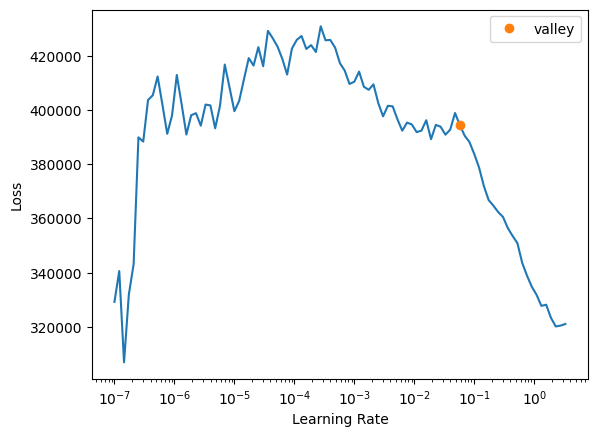

In [8]:
#this function also doesn't work with the small example set
#but when you have a lot of data it helps to find the right learning rate
learn.lr_find()

## Train the Model
In the next step wie train the model with the selected Learning Rate for over 6 Epochs

In [9]:
learn.fine_tune(6, 0.05)

epoch,train_loss,valid_loss,,time
0,330748.906250,975424.125000,949.171570,01:25


epoch,train_loss,valid_loss,,time
0,157812.390625,1575649.500000,721.189209,06:39
1,125381.265625,1239493.500000,769.343384,11:00
2,99407.875000,119452.234375,425.006805,09:45
3,73867.703125,46726.687500,302.605560,09:01
4,54881.980469,42828.519531,316.879883,10:08
5,40558.769531,39528.304688,313.998840,08:59


In [10]:
def get_predictions(df, image_path):
    example_test_watches = df["image_name"].values 
    example_test_price = df["price"].values 

    predictions = []
    for watch in example_test_watches:
        predictions.append(int(learn.predict(str(image_path) + "/" + watch)[1]))
        
    return predictions, example_test_price

In [11]:
%%capture
### TIME INFORMATION: needs 1,5 Minutes to run on M1
y_pred, y_test = get_predictions(df_test, path_imdb);
y_pred_train, y_train = get_predictions(df_train, path_imdb);

In [12]:
print(f"The R2 score of the model on the Test Data is: {r2_score(y_test, y_pred)}")
print(f"The R2 score of the model on the Train Data is: {r2_score(y_train, y_pred_train)}")

The R2 score of the model on the Test Data is: 0.7581441581998731
The R2 score of the model on the Train Data is: 0.9006207875042472


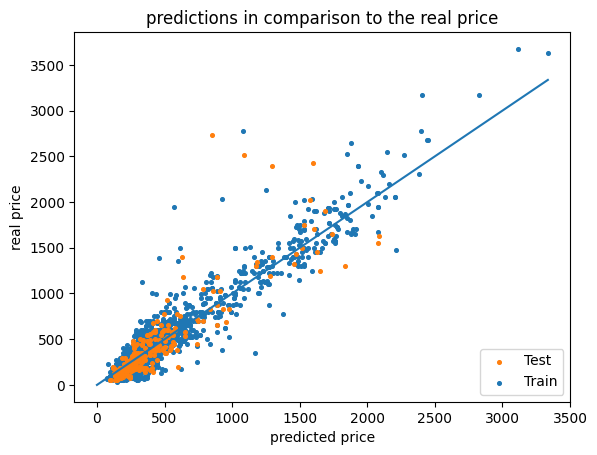

In [13]:
fig, ax = plt.subplots()

train = ax.scatter(y_pred_train, y_train, s=7, label ="Train")
test = ax.scatter(y_pred, y_test, s=7, label= "Test")

ax.plot([0,max(y_pred_train)], [0,max(y_pred_train)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test, train], loc='lower right')

plt.show()

In [14]:
## save model to storage
import dill
serialized_function = dill.dumps(learn)

with open("models/M3_RN_ds1.pickle", mode="wb") as out_file:
    pickle.dump(serialized_function, out_file)

## Test Model on other Dataset

In [15]:
ds2_path_wiki = 'data/watches/ds2_marc/cleandata.csv'
ds2_path_imdb = 'data/watches/ds2_marc/images/'

In [16]:
df_ds2 = pd.read_csv(ds2_path_wiki, index_col=0)

In [17]:
%%capture
y_pred_ds2, all_label_ds2 = get_predictions(df_ds2, ds2_path_imdb);

In [18]:
print(f"The R2 score on the Marc Gebauer Data is: {r2_score(all_label_ds2, y_pred_ds2)}")

The R2 score on the Marc Gebauer Data is: -0.31153943115685334


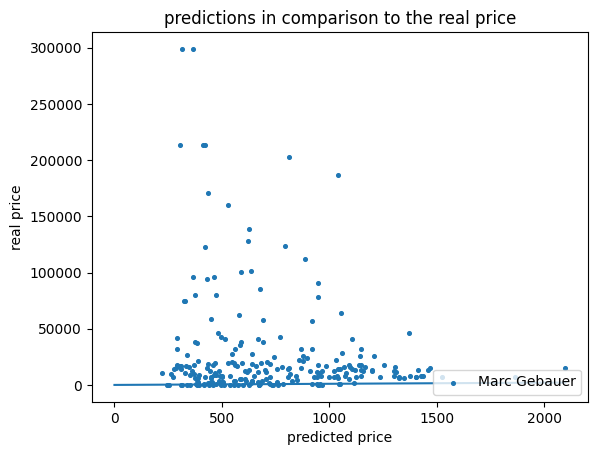

In [19]:
fig, ax = plt.subplots()

test = ax.scatter(y_pred_ds2, all_label_ds2, s=7, label ="Marc Gebauer")

ax.plot([0,max(y_pred_ds2)], [0,max(y_pred_ds2)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test], loc='lower right')

plt.show()

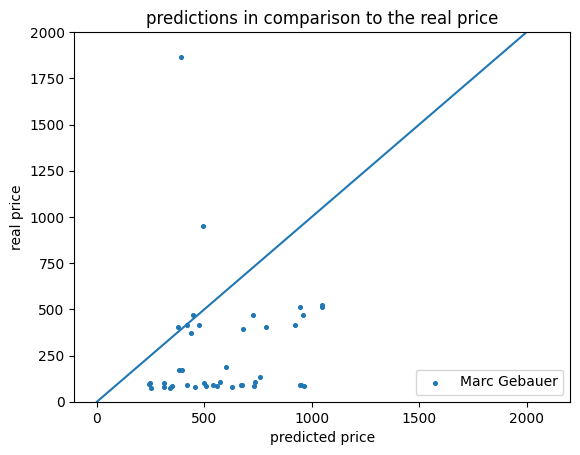

In [20]:
fig, ax = plt.subplots()

test = ax.scatter(y_pred_ds2, all_label_ds2, s=7, label ="Marc Gebauer")

ax.plot([0,max(y_pred_ds2)], [0,max(y_pred_ds2)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test], loc='lower right')

ax.set_ylim(0, 2000)  

plt.show()